In [71]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from analysis_util import *
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib.ticker import MaxNLocator
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from torch_util import *

import pickle
import seaborn as sns

import itertools


'''this script test the hypothesis whether people respond to a fixed bound
pepole  '''
# global setting f
plt.rcParams.update({"font.size": 18})
colors = sns.color_palette("deep")
sns.set(style="whitegrid")
# top level dir 
# 






In [72]:

PROJECT_DIR = "/data/rwchain-all/round2"
BEH_DIR = os.path.join(PROJECT_DIR, "rwchain-beh/data")
EEG_DIR = os.path.join(PROJECT_DIR, "rwchain-eeg")
ALL_BEH_DIR = os.path.join(PROJECT_DIR, 'rwchain-beh', 'combined')


In [73]:
CODE_DIR = "/home/jenny/evidence-chain/"
FIG_DIR = os.path.join(CODE_DIR, "figs/xgb_local_position_evidence_acc_aligned/")


In [74]:

# Check if the directory exists
if not os.path.exists(FIG_DIR):
    # Create the directory
    os.makedirs(FIG_DIR)
    print(f"Directory '{FIG_DIR}' was created.")
else:
    print(f"Directory '{FIG_DIR}' already exists.")



Directory '/home/jenny/evidence-chain/figs/xgb_local_position_evidence_acc_aligned/' already exists.


In [75]:
stimdur = '100'
pos = 0
evaluate_mode = False

In [76]:

list_of_subj = os.listdir(BEH_DIR)
list_of_subj.sort()
# list_of_subj = [list_of_subj[5]]

df = pd.read_pickle(os.path.join(ALL_BEH_DIR, 'all_df_concat.pkl'))
# organize some columsn
 
df['key'][df['key'] == '[5]'] = 1
df['key'][df['key'] == '[3]'] = 1
df['key'][df['key'] == '[2]'] = 0
df['cumsum'] = df['sequence_clean'].apply(lambda x: [sum(x[:i+1]) for i in range(len(x))])

# get rid of a ;pw acc subject
df = df[df['sid']!='s108']

if stimdur == '100':
    df = df[df['stimDur'] == 0.1]
if stimdur == '250':
    df = df[df['stimDur'] == 0.25]
# df = df[df['stimDur'] != 0.5]
# df = df[df['stimDur'] != 0.05]
# df = df[df['stimDur'] == 0.1]



/tmp/ipykernel_1585848/100844696.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[5]'] = 1
/tmp/ipykernel_1585848/100844696.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[3]'] = 1
/tmp/ipykernel_1585848/100844696.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[2]'] = 0


In [77]:
# correct the count
df = correct_samples_by_condition(df)

cumsum = np.array(df['cumsum'].to_list())
sequence =  np.array(df['sequence_clean'].to_list())
count = df['count_corrected'].to_numpy()

In [78]:
df.shape

(3450, 13)

In [79]:
df.head()


,time,bytetime,press,count,key,stimDur,Bias,sequence,block,sequence_clean,sid,cumsum,count_corrected
100,1.3500020503997803,1345,[1],13,1,0.1,0.12,[ 1. -1. 1. -1. 1. -1. -1. 1. 1. 1. 1. ...,2,"[1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1...",s102,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, -1.0, 0.0, 1.0,...",11
101,1.249974012374878,1234,[1],12,0,0.1,0.12,[-1. -1. 1. 1. -1. -1. 1. 1. -1. 1. -1. -...,2,"[-1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -...",s102,"[-1.0, -2.0, -1.0, 0.0, -1.0, -2.0, -1.0, 0.0,...",10
102,1.399996042251587,1396,[1],13,1,0.1,0.12,[-1. -1. 1. -1. 1. -1. 1. 1. 1. -1. 1. ...,2,"[-1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1...",s102,"[-1.0, -2.0, -1.0, -2.0, -1.0, -2.0, -1.0, 0.0...",11
103,2.3166611194610596,2306,[1],23,1,0.1,0.12,[ 1. -1. 1. 1. 1. 1. -1. -1. -1. 1. -1. ...,2,"[1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1...",s102,"[1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 3.0, 2.0, 1.0, ...",21
104,1.0333290100097656,1017,[1],10,0,0.1,0.12,[-1. -1. -1. -1. 1. -1. 1. -1. -1. -1. 1. ...,2,"[-1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0,...",s102,"[-1.0, -2.0, -3.0, -4.0, -3.0, -4.0, -3.0, -4....",8


In [80]:

# calculate terminated chains
cumsum_stop_list = []

for c in range(cumsum.shape[0]):
    cumsum_stop = cumsum[
        c, : int(count[c]+1)
    ]  # for example, if rt adjusted i 708, for 250ms, one have seen 3 stimulus.
    cumsum_stop_list.append(cumsum_stop)
 
level_at_response = [i[-1] for i in cumsum_stop_list]
resp = df['key'].tolist()

acc = []
bound = []
for num, k in zip(level_at_response, resp):
    if (num <= 0 and k == 0) or (num >= 0 and k == 1):
        acc.append(1)
    else:
        acc.append(0)
    bound.append(np.abs(num))
df['acc'] = acc
df['bound'] = bound

In [81]:
# create a matrix of +1 and -1 with NaNs if the chain terminates

chain_matrix = get_chain_matrix(sequence, count)


In [82]:
df.iloc[90:95]

,time,bytetime,press,count,key,stimDur,Bias,sequence,block,sequence_clean,sid,cumsum,count_corrected,acc,bound
240,1.5333268642425537,235673,[1],15,1,0.1,0.12,[-1. -1. -1. 1. -1. 1. 1. 1. -1. 1. 1. ...,4,"[-1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -...",s102,"[-1.0, -2.0, -3.0, -2.0, -3.0, -2.0, -1.0, 0.0...",13,1,2.0
241,2.4666450023651123,240825,[1],24,0,0.1,0.12,[-1. 1. 1. 1. -1. -1. 1. -1. -1. 1. 1. -...,4,"[-1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -...",s102,"[-1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, -1.0...",22,1,5.0
242,1.283336877822876,244580,[1],12,0,0.1,0.12,[-1. 1. 1. -1. 1. -1. -1. 1. -1. 1. 1. -...,4,"[-1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -...",s102,"[-1.0, 0.0, 1.0, 0.0, 1.0, 0.0, -1.0, 0.0, -1....",10,0,1.0
243,0.94999098777771,248195,[1],9,1,0.1,0.12,[ 1. -1. 1. 1. 1. 1. 1. -1. 1. -1. 1. ...,4,"[1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0...",s102,"[1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 4.0, 5.0, ...",7,1,4.0
244,1.7332851886749268,252196,[1],17,0,0.1,0.12,[-1. 1. 1. 1. 1. 1. 1. -1. -1. -1. 1. -...,4,"[-1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1....",s102,"[-1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 4.0, 3.0,...",15,0,4.0


In [83]:


cumsum = np.array(df[df['acc']==1]['cumsum'].to_list())
sequence =  np.array(df[df['acc']==1]['sequence_clean'].to_list())
count = df[df['acc']==1]['count_corrected'].to_numpy()

chain_matrix = get_chain_matrix(sequence, count)



In [84]:
acc = df[df['acc']==1]['acc'].tolist() 
bound  = df[df['acc']==1]['bound'].tolist()

In [85]:
len(acc)

2939

In [86]:
# get the chains where 
chain_length = 0




In [87]:
ind = np.sum(~np.isnan(chain_matrix),axis=1)>=chain_length
chain_matrix2 = chain_matrix[ind,:]

valid_ind = np.argmax(np.isnan(chain_matrix2), axis=1) -1

In [88]:
chain_matrix_cumsum = np.cumsum(chain_matrix2, axis=1)

In [89]:
evidence = chain_matrix_cumsum[np.arange(0,len(valid_ind)), valid_ind]

In [90]:
chain_matrix3 = chain_matrix2.copy()
chain_matrix3[evidence<0] = chain_matrix3[evidence<0] * -1  # such that the chain is positive if it's towardd final choice

In [91]:
sequence_cumsum = np.cumsum(sequence, axis=1)
evidence_sequece = sequence_cumsum[:, -1]
sequence2 = sequence.copy()
sequence2[evidence_sequece<0] = sequence2[evidence_sequece<0] * -1

In [92]:
evidence[evidence<0]

array([ -1.,  -5.,  -6., ...,  -7.,  -6., -10.])

In [93]:
# generate permutations of all possible permutations

In [94]:

# Set the number of elements in each permutation
n = 4

# Generate all permutations of 1 and -1 of length n
perms = list(itertools.product([1, -1], repeat=n))



In [95]:

column_names = ['local_signal', 'chain_idx', 'pos_end', 'evidence_end', 'termination', 'acc']
df = pd.DataFrame(columns=column_names)

In [96]:
local_signal = []
chain_idx = []
pos_end =[]
evidence_end = []
termination = []
acc_if_term = []

for target in perms:
    target_length = len(target)   #length of 4
    for idx, chain in enumerate(chain_matrix3):
        ind_stop = np.argmax(np.isnan(chain))
        chain_cumsum = np.cumsum(chain)
        # within each chain
        for i in range(len(chain)-target_length+1):
            term = 0
            accuracy = 0
            if tuple(chain[i:i+target_length]) == target:
                local_signal.append(target)
                chain_idx.append(idx)
                pos_end.append(i+target_length)
                evidence_end_local = chain_cumsum[i+target_length-1]
                evidence_end.append(evidence_end_local)
                if evidence_end_local<0:
                    local_signal.pop()
                    local_signal.append(tuple([i * -1 for i in list(target)]))
                if i+target_length == ind_stop:
                    term =1
                    if acc[idx] == 1:
                       accuracy = 1 
                termination.append(term)
                acc_if_term.append(accuracy)

In [97]:
evidence_end = np.abs(evidence_end)

In [98]:
data = {'local_signal': local_signal,
'chain_idx': chain_idx,
 'pos_end': pos_end,
# 'evidence_end': np.abs(evidence_end),
'evidence_end':evidence_end,

'termination': termination,
'acc': acc_if_term
}

df = pd.DataFrame(data)

In [99]:
mydict = {}
evidence_values = []
for target in perms:
    mydict[target] = None
    target_length = len(target)
    occurance =  0
    term = 0
    term_correct = 0
    for idx, chain in enumerate(chain_matrix3):
        ind_stop = np.argmax(np.isnan(chain))
        chain_cumsum = np.cumsum(chain)
        for i in range(len(chain)-target_length+1):
            
            if tuple(chain[i:i+target_length]) == target:
                occurance +=1
                if i+target_length == ind_stop:
                    term +=1
                    if acc[idx] == 1:
                        term_correct +=1 
    mydict[target] = [occurance, term, term/occurance, term_correct, term_correct/occurance]
    
    

In [100]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

In [101]:
dataset = np.zeros((len(df), 6))

Text(0.5, 0, 'evidence')

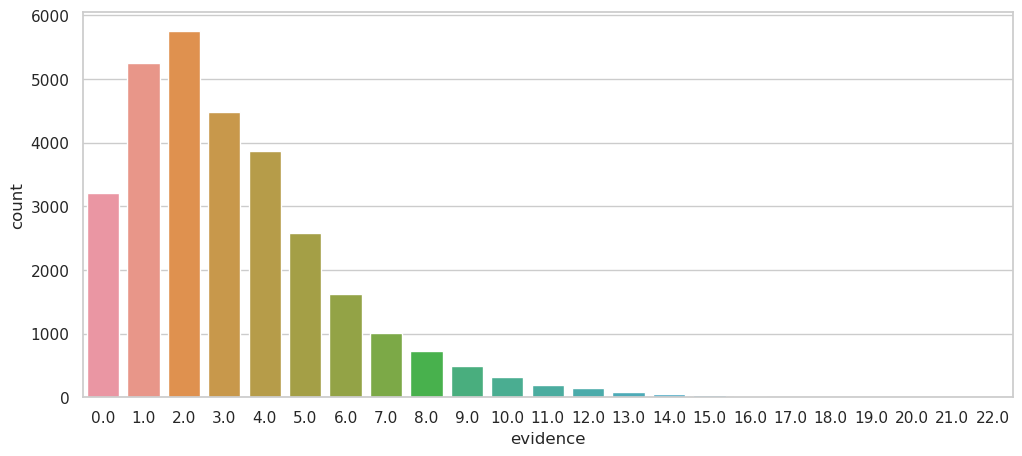

In [102]:
fig, ax = plt.subplots(1, figsize = (12,5))
sns.countplot(x=df['evidence_end'],ax = ax)
ax.set_xlabel("evidence")

In [103]:
sum(df['evidence_end'] >=9) /len(df)

0.045091859997317955

In [104]:
ind = df['evidence_end'] <=8

In [105]:
local_signal_array = [np.array(i) for i in local_signal]

In [106]:
dataset[:,0:4] = local_signal_array

In [107]:
dataset[:,4] = evidence_end
dataset[:,5] = pos_end

In [108]:
list_of_feautres = ["local_0", "local_1", "local_2", "local_3", "evidence", "position"]

In [109]:
# one hot encode 
dataset[:,0:4][dataset[:,0:4] == -1] = 0

In [110]:
dataset_resp = np.array(termination)

In [111]:
dataset = dataset[:,0:6]
list_of_feautres = list_of_feautres[0:6]

In [112]:
dataset.shape

(29828, 6)

In [113]:
# select the low evidence trials

dataset = dataset[ind,:]

In [114]:
dataset_resp = dataset_resp[ind]

In [115]:
    # train test val split
x_train, x_test, y_train, y_test = train_test_split(
    dataset, dataset_resp, test_size=0.2, random_state=1
)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.25, random_state=1
)

In [116]:


# create a dictionary containing the hyperparameters
# to tune and the range of values to try
PARAMETERS = {
    "subsample": [0.75, 1],
    "gamma": [0.5, 1.5, 5],
    "colsample_bytree": [0.75, 1],
    "max_depth": [3, 4, 5, 6],
    "min_child_weight": [1, 5],
    #               "tree_method":['gpu_hist'],
    "learning_rate": [0.1, 0.01, 0.05],
}


# create a validation set which will be used for early stopping
eval_set = [(x_train, y_train), (x_val, y_val)]
# initialise an XGBoost classifier, set the number of estimators,
# evaluation metric & early stopping rounds
estimator = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=100,
    seed=42
    #                             tree_method = 'gpu_hist',
    #                              gpu_id =1
)

# initialise GridSearchCV model by passing the XGB classifier we
# initialised in the last step along with the dictionary of parameters
# and values to try. We also set the number of folds to validate over
# along with the scoring metic to use
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=PARAMETERS,
    cv=7,
    n_jobs=10,
    verbose=0,
    scoring="roc_auc",
    return_train_score=True,
)

In [117]:
# fit model
clf = grid_search.fit(
    x_train,
    y_train,
    eval_set=eval_set,
    eval_metric=["auc"],
    early_stopping_rounds=10,
    verbose=0,
)


/home/jenny/anaconda3/envs/echain/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/jenny/anaconda3/envs/echain/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/jenny/anaconda3/envs/echain/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/jenny/anaconda3/envs/echain/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

/home/jenny/anaconda3/envs/echain/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/jenny/anaconda3/envs/echain/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/jenny/anaconda3/envs/echain/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/jenny/anaconda3/envs/echain/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

In [118]:
print(clf.best_score_, clf.best_params_)

0.685629686475514 {'colsample_bytree': 1, 'gamma': 1.5, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 1}


In [119]:
mymodel = clf.best_estimator_

In [120]:
mymodel

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [121]:
mymodel.fit(
    x_train,
    y_train,
    early_stopping_rounds=15,
    eval_metric=["auc", "logloss"],
    eval_set=eval_set,
    verbose=False,
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

0.7040229103172292
0.687647842745294
0.6964690914801097


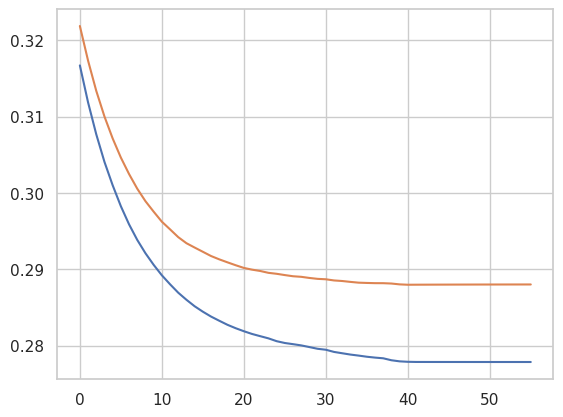

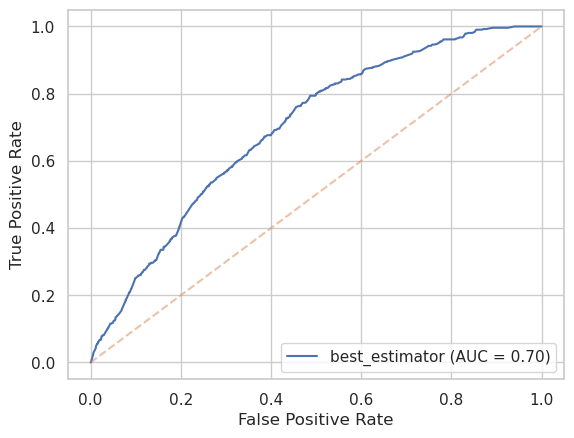

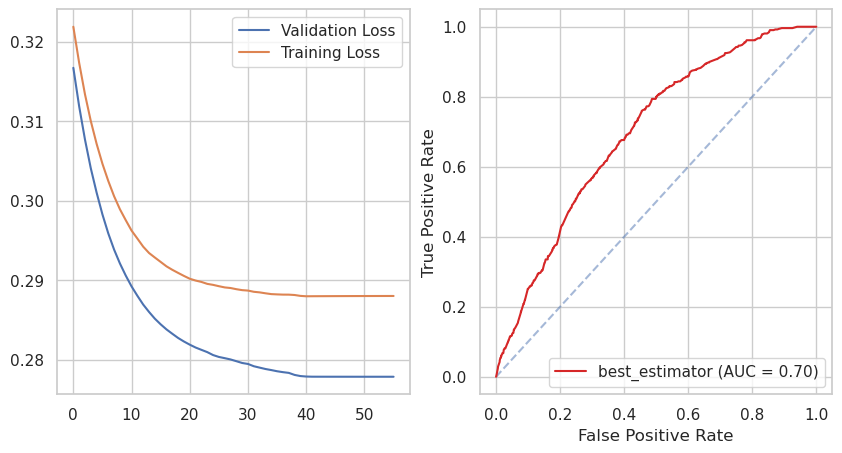

In [122]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_prob_train = mymodel.predict_proba(x_train)
y_pred_prob_val = mymodel.predict_proba(x_val)

y_pred_prob_test = mymodel.predict_proba(x_test)






fpr_train, tpr_train, _ = metrics.roc_curve(y_train, y_pred_prob_train[:, 1])
fpr_val, tpr_val, _ = metrics.roc_curve(y_val, y_pred_prob_val[:, 1])
fpr_test, tpr_test, _ = metrics.roc_curve(y_test, y_pred_prob_test[:, 1])

auc_train = metrics.auc(fpr_train, tpr_train)
auc_val = metrics.auc(fpr_val, tpr_val)
auc_test = metrics.auc(fpr_test, tpr_test)

print(auc_train)
print(auc_val)
print(auc_test)


results = mymodel.evals_result()
plt.plot(results["validation_0"]["logloss"])
plt.plot(results["validation_1"]["logloss"])
x_train.shape
booster: xgb.Booster = mymodel.get_booster()
scores = mymodel.predict_proba(x_test)

fpr, tpr, thresh = metrics.roc_curve(y_test, scores[:, 1])

roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(
    fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="best_estimator"
)
display.plot()
plt.plot(np.linspace(0, 1), np.linspace(0, 1), "--", alpha=0.5)
plt.show()



fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].plot(results["validation_0"]["logloss"], label = "Validation Loss")
ax[0].plot(results["validation_1"]["logloss"], label = "Training Loss")
ax[1].plot(np.linspace(0, 1), np.linspace(0, 1), "--", alpha=0.5)
display = metrics.RocCurveDisplay(
    fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="best_estimator",
)
display.plot(ax=ax[1], color="tab:red")
ax[0].legend()
fig.savefig(f'{FIG_DIR}performance_all{stimdur}.png', dpi=300, bbox_inches='tight')


In [123]:
mymodel

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [124]:
from sklearn.inspection import PartialDependenceDisplay

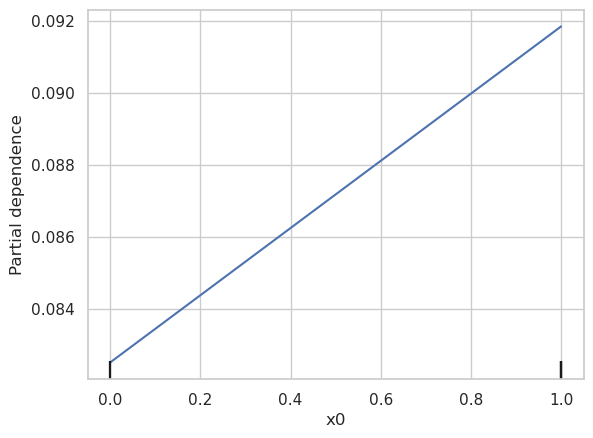

In [125]:
PartialDependenceDisplay.from_estimator(mymodel, x_train, [0])

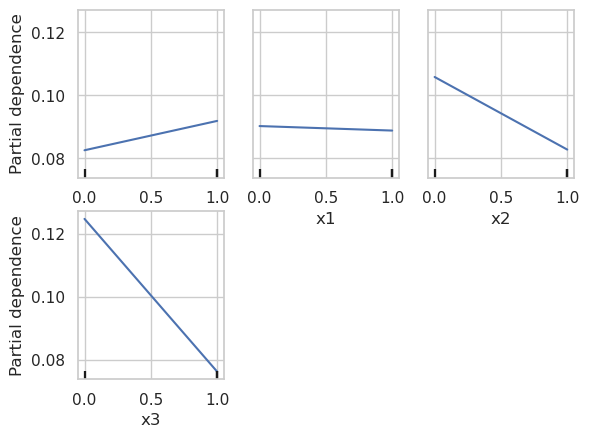

In [126]:

a = PartialDependenceDisplay.from_estimator(mymodel, x_train, [0,1,2,3])


In [127]:
from sklearn.inspection import partial_dependence

partial_dependence(mymodel, x_train, [1])


/home/jenny/anaconda3/envs/echain/lib/python3.11/site-packages/sklearn/utils/_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


{'grid_values': [array([0., 1.])],
 'values': [array([0., 1.])],
 'average': array([[0.09020344, 0.08877242]], dtype=float32)}

In [128]:
list_of_feautres

['local_0', 'local_1', 'local_2', 'local_3', 'evidence', 'position']

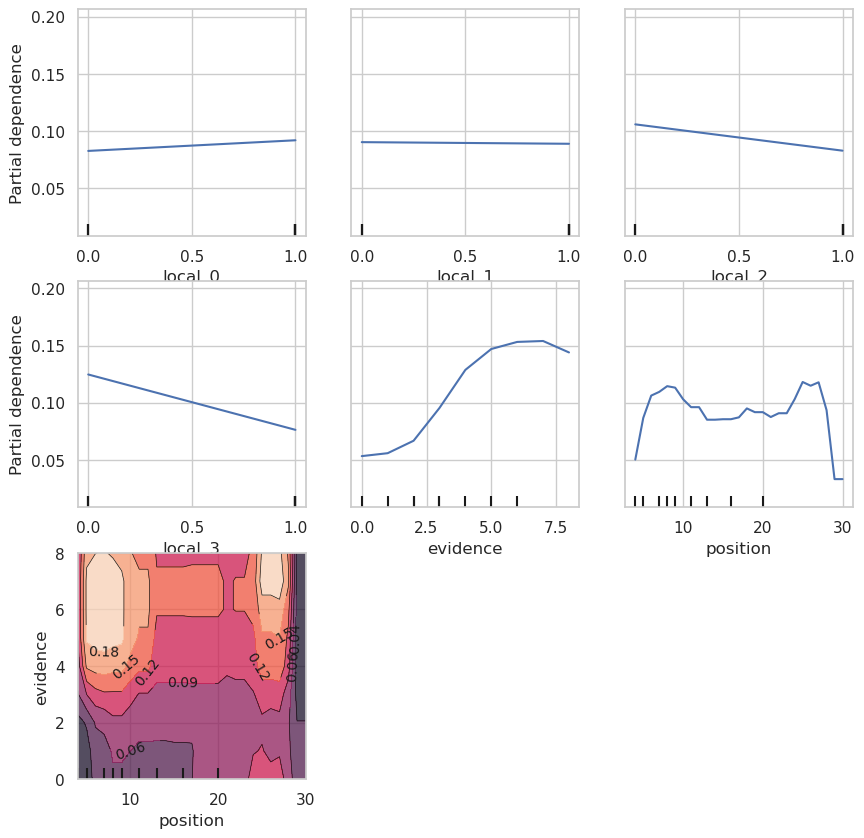

In [129]:
handle = PartialDependenceDisplay.from_estimator(mymodel, x_train, [0, 1,2,3,4, 5, (5,4)], feature_names = list_of_feautres,
                                                kind="average", subsample=100)
fig, axes = handle.figure_, handle.axes_
fig.set_figwidth(10)
fig.set_figheight(10)

heatmap = handle.heatmaps_


In [130]:
length = len(dataset)
np.random.seed(2024)
sample_ind = np.random.choice(np.arange(0,length), size=100, replace=False)

In [131]:
    mydict = partial_dependence(mymodel, features=[4], X=dataset, percentiles=(0, 1),grid_resolution=2, kind='both',
                                feature_names = list_of_feautres,
    )

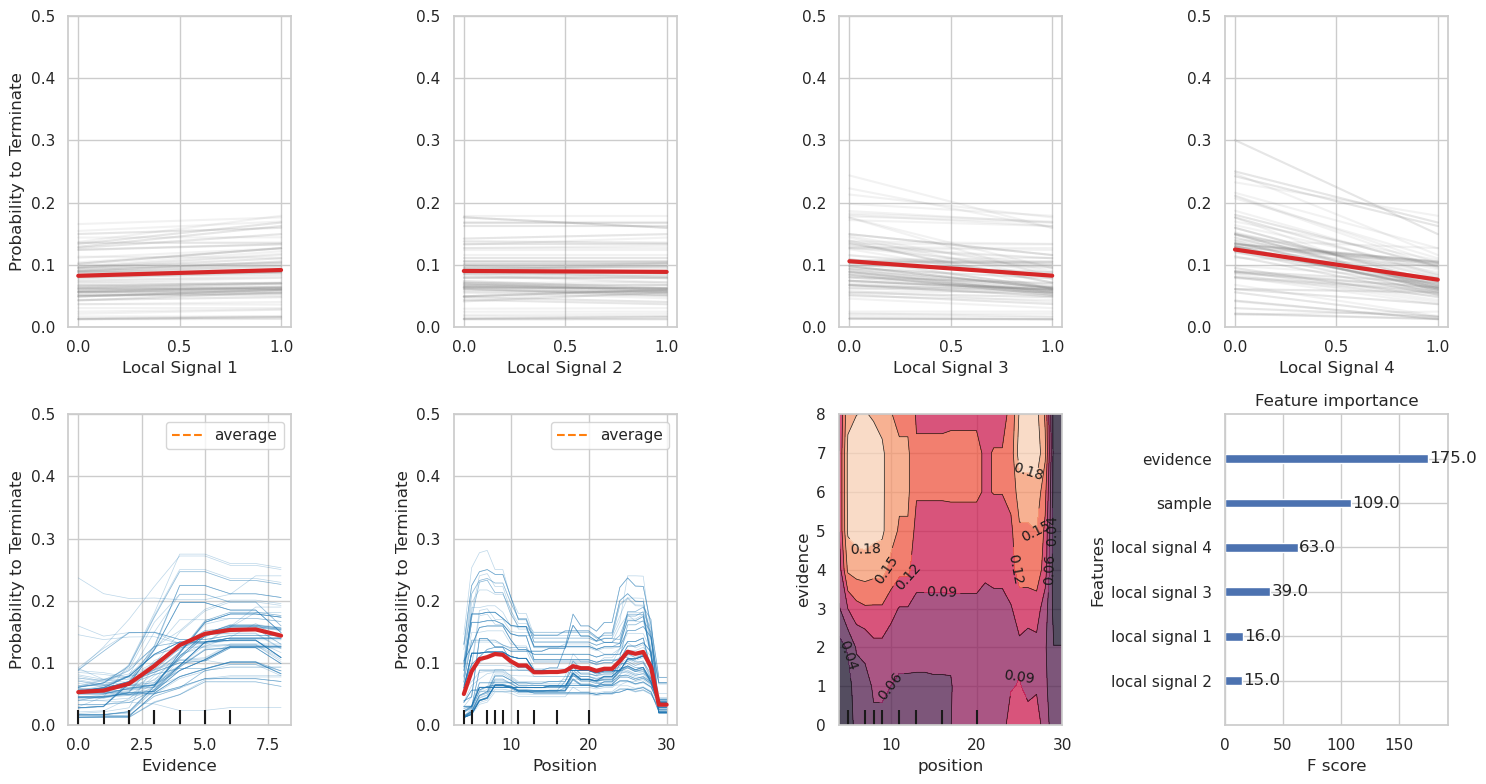

In [132]:
fig, ax = plt.subplots(2,4,figsize = (15,8))
ax=ax.flatten()


for ind, a in enumerate(ax[0:4]):
    mydict = partial_dependence(mymodel, features=[ind], X=dataset, percentiles=(0, 1),grid_resolution=2, kind='both',
                                feature_names = list_of_feautres,
    )
    a.plot([np.zeros(100), np.ones(100)],   [mydict['individual'][0][sample_ind,0],  
                                             mydict['individual'][0][sample_ind,1]],alpha=0.1, color= "grey", label = "individual samples")
    a.plot(mydict['grid_values'][0], mydict['average'][0], 
           color= "tab:red" , linewidth = 3, alpha=1, label = "average")

    a.set_xlabel(f"Local Signal {ind+1}") 
    a.set_ylim(0,0.5)
# fig.legend()
ax[0].set_ylabel("Probability to Terminate")
PartialDependenceDisplay.from_estimator(mymodel, x_train, [(5,4)], feature_names = list_of_feautres,
                                                kind="average", ax=ax[6])
ax[6].set_xlabel("Sample")
ax[6].set_ylabel("Evidence")

h1 = PartialDependenceDisplay.from_estimator(mymodel, x_train, [4], feature_names = list_of_feautres,
                                                kind="both", ax=ax[4], subsample=100)
h2 = PartialDependenceDisplay.from_estimator(mymodel, x_train, [5], feature_names = list_of_feautres,
                                                kind="both", ax=ax[5],subsample=100)
for ah in h1.axes_.ravel():
    avg_line = ah.get_lines()[-1]
    avg_line.set_color('tab:red')  # set the average line color to black
    avg_line.set_linewidth(3) 
    avg_line.set_linestyle("-") 
    ah.set_ylim(0,0.5)
    ah.set_ylabel("Probability to Terminate")
    ah.set_xlabel("Evidence")


for ah in h2.axes_.ravel():
    avg_line = ah.get_lines()[-1]
    avg_line.set_color('tab:red')  # set the average line color to black
    avg_line.set_linewidth(3) 
    avg_line.set_linestyle("-") 
    ah.set_ylim(0,0.5)
    ah.set_ylabel("Probability to Terminate")
    ah.set_xlabel("Position")
mymodel.get_booster().feature_names = ["local signal 1", "local signal 2", "local signal 3", "local signal 4", "sample", "evidence", ]
xgb.plot_importance(mymodel, grid=True, importance_type="weight", ax=ax[-1])

fig.tight_layout()

fig.savefig(f'{FIG_DIR}partial_dependency_subplot_{stimdur}.png', dpi=300, bbox_inches='tight')


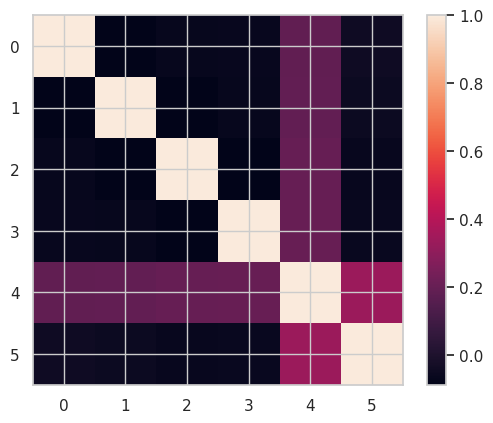

In [133]:
corr_coef = np.corrcoef(x_train.T, rowvar= True)
plt.imshow(corr_coef)
plt.colorbar()

In [134]:
corr_coef[np.triu_indices(4)]

array([ 1.        , -0.08810202, -0.0703963 , -0.06615057,  1.        ,
       -0.08435183, -0.07106691,  1.        , -0.08589879,  1.        ])

In [135]:
corr_coef

array([[ 1.        , -0.08810202, -0.0703963 , -0.06615057,  0.18573257,
        -0.04503651],
       [-0.08810202,  1.        , -0.08435183, -0.07106691,  0.19154326,
        -0.05202299],
       [-0.0703963 , -0.08435183,  1.        , -0.08589879,  0.19698133,
        -0.06268994],
       [-0.06615057, -0.07106691, -0.08589879,  1.        ,  0.20279837,
        -0.05848509],
       [ 0.18573257,  0.19154326,  0.19698133,  0.20279837,  1.        ,
         0.33676767],
       [-0.04503651, -0.05202299, -0.06268994, -0.05848509,  0.33676767,
         1.        ]])

In [136]:
def get_local(data_x, data_y):

    local_signal = []
    pos_end =[]
    evidence_end = []
    termination = []


    for target in perms:
        target_length = len(target)   #length of 4
        for idx, chain in enumerate(data_x):
            if data_y[idx]:
                ind_stop = data_x.shape[1]
        
            else:
                ind_stop = 0
            chain_cumsum = np.cumsum(chain)  # evidence is + towards 0, - towards x
            # within each chain
            for i in range(len(chain)-target_length+1):
                term = 0
                if tuple(chain[i:i+target_length]) == target:
                    local_signal.append(target)
                    pos_end.append(i+target_length)
                    evidence_end_local = chain_cumsum[i+target_length-1]
                    evidence_end.append(evidence_end_local)
                    if evidence_end_local<0:
                        local_signal.pop()
                        local_signal.append(tuple([i * -1 for i in list(target)])) # now 
                    if i+target_length == ind_stop:
                        term =1
                    termination.append(term)
    return local_signal, pos_end, evidence_end, termination


In [137]:

position_range = np.arange(3,15)

TRUE_N = []
TOTAL_N = []
FPR_TRAIN =[]
FPR_TEST =[]
TPR_TRAIN=[]
TPR_TEST=[]
AUC_TRAIN =[]
AUC_TEST =[]
POSITION_OF_SAMPLES=[]
N_TRAIN =[]
N_TEST = []
AUC_THRESH_TRAIN = []
AUC_THRESH_TEST =[]

for position_terminate in position_range:
    
    dataset, dataset_resp = make_dataset(position_terminate, count, chain_matrix)
    TRUE_N.append(dataset_resp.sum())
    TOTAL_N.append(len(dataset))
    indices = np.arange(len(dataset))
    x_train, x_test, y_train, y_test, indices_train, indices_test = train_test_split(
        dataset, dataset_resp, indices, test_size=0.3, random_state=2024
    )
    N_TRAIN.append(len(x_train))
    N_TEST.append(len(x_test))

    local_signal_train, pos_end_train, evidence_end_train, termination_train = get_local(x_train, y_train)
    local_signal_test, pos_end_test, evidence_end_test, termination_test = get_local(x_test, y_test)
    
    local_signal_train_array = np.array([np.array(i) for i in local_signal_train])
    dataset_train = np.zeros((len(local_signal_train_array), 6))
    dataset_train[:,0:4] = local_signal_train_array

    dataset_train[:,0:4] = [np.array(i) for i in local_signal_train]
    dataset_train[:,4] = np.abs(evidence_end_train)
    dataset_train[:,5] = pos_end_train
    dataset_resp_train = np.array(termination_train)
    



    local_signal_test_array = np.array([np.array(i) for i in local_signal_test])
    dataset_test = np.zeros((len(local_signal_test_array), 6))
    dataset_test[:,0:4] = local_signal_test_array

    dataset_test[:,0:4] = [np.array(i) for i in local_signal_test]
    dataset_test[:,4] = np.abs(evidence_end_test)
    dataset_test[:,5] = pos_end_test
    dataset_resp_test = np.array(termination_test)
    
    # integrate evidence    
    



    y_pred_prob_train =  mymodel.predict_proba(dataset_train)
    y_pred_prob_test = mymodel.predict_proba(dataset_test)

    # # plot ROC
    fpr_train, tpr_train, thresh_train = metrics.roc_curve(termination_train, y_pred_prob_train[:,1])
    fpr_test, tpr_test, thresh_test = metrics.roc_curve(termination_test, y_pred_prob_test[:,1])
    auc_train = metrics.auc(fpr_train, tpr_train)
    auc_test = metrics.auc(fpr_test, tpr_test)
    
    
    FPR_TRAIN.append(fpr_train)
    FPR_TEST.append(fpr_test)
    TPR_TRAIN.append(tpr_train)
    TPR_TEST.append(tpr_test)
    AUC_TRAIN.append(auc_train)
    AUC_TEST.append(auc_test)
    POSITION_OF_SAMPLES.append(position_terminate)
    AUC_THRESH_TRAIN.append(thresh_train)
    AUC_THRESH_TEST.append(thresh_test)


In [138]:
ind_auc = [i for i, j in enumerate(AUC_TRAIN) if j>0.5 and (AUC_TEST[i]) >0.5]

In [139]:
GMEANS_train=[]
IDX_train=[]
for i in range(len(TPR_TRAIN)):
    gmeans = np.sqrt(TPR_TRAIN[i] * (1-FPR_TRAIN[i]))
    ix = np.argmax(gmeans)
    GMEANS_train.append(AUC_THRESH_TRAIN[i][ix])
    IDX_train.append(ix)

GMEANS_test=[]
IDX_test=[]
for i in range(len(TPR_TEST)):
    gmeans = get_gmeans(TPR_TEST[i], FPR_TEST[i])
    ix = np.argmax(gmeans)
    GMEANS_test.append(AUC_THRESH_TEST[i][ix])
    IDX_test.append(ix)

/home/jenny/evidence-chain/analysis/analysis_util.py:216: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(
/home/jenny/evidence-chain/analysis/analysis_util.py:220: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot([i + 1 for i in position_of_samples], auc_list_test, "-o", label="Test",alpha=alpha,marker =marker, markeredgecolor=markeredgecolor)


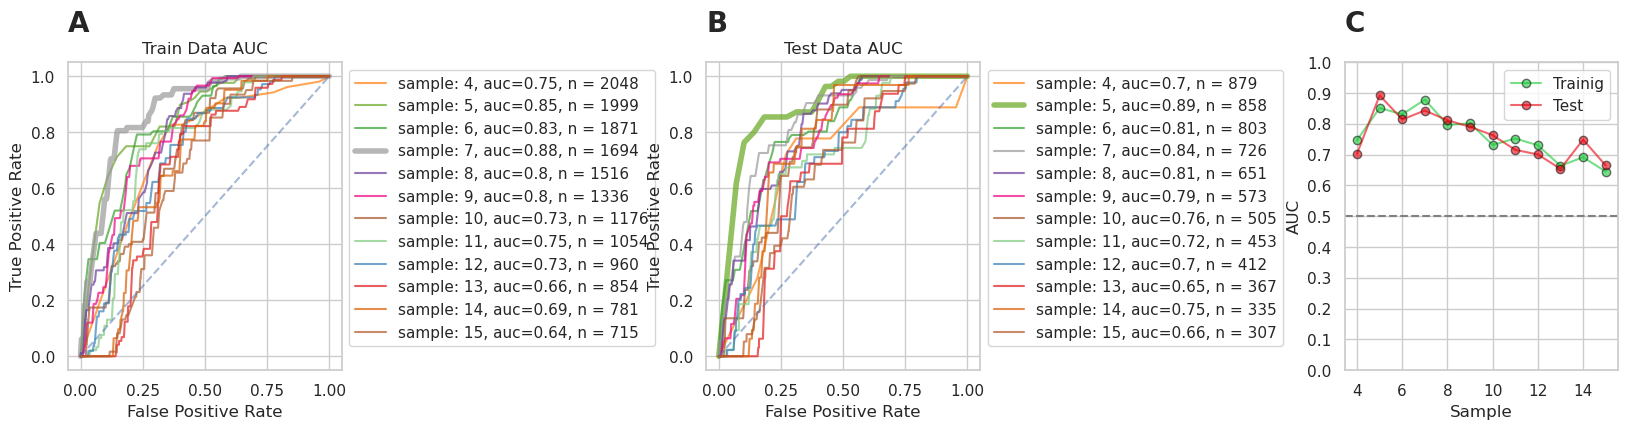

In [140]:
# Overall plots
import string 
colors_b = sns.color_palette("bright")

color_train = colors_b[2]
color_test =  colors_b[3]
alpha = 0.6

# creating grid for subplots
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(20)
 
ax1 = plt.subplot2grid(shape=(1, 10), loc=(0, 0), colspan=2)
ax2 = plt.subplot2grid(shape=(1, 10), loc=(0, 4), colspan=2)
ax3 = plt.subplot2grid(shape=(1, 10), loc=(0, 8), colspan=2)



# ax1 and ax2
_,ax1 = plot_roc(FPR_TRAIN,TPR_TRAIN,AUC_TRAIN, position_range+1, N_TRAIN, auc_cutoff = 0.1, ax=ax1, label="sample",indices=ind_auc)
_,ax2 = plot_roc(FPR_TEST,TPR_TEST,AUC_TEST, position_range+1, N_TEST, auc_cutoff = 0.1, ax=ax2, label="sample",indices=ind_auc)
ax1.set_title("Train Data AUC")
ax2.set_title("Test Data AUC")

# ax3 
ig_, ax3 = plot_roc_per_sample_position(POSITION_OF_SAMPLES, AUC_TRAIN, AUC_TEST,marker = 'o',ax=ax3,alpha=alpha, markeredgecolor="k")
ax3.axhline(y=0.5, color ='grey', ls='--')
ax3.xaxis.set_major_locator(MaxNLocator(integer=True))
ax3.set_yticks(np.arange(0,1.1,0.1))

ax3.get_lines()[0].set_color(color_train)
ax3.get_lines()[1].set_color(color_test)
ax3.legend()



axs = [ax1,ax2, ax3]
for n, ax in enumerate(axs):
    ax.text(0, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')

fig.subplots_adjust(hspace=0.3)
fig.subplots_adjust(wspace=0.4)

# fig.tight_layout()

fig.savefig(f'{FIG_DIR}summary_subplot_{stimdur}.png', dpi=300, bbox_inches='tight')